In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from tqdm import tqdm, trange
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import pandas as pd
data = pd.read_csv("HLPerDay.csv")
data

,Unnamed: 0,Material,Wholesaler,HLs,Dates
0,0,10946,29606863,"[16.8, 16.8, 16.8, 79.8, 12.6, 21.0, 16.8, 16....","[Timestamp('2019-08-12 00:00:00'), Timestamp('..."
1,1,10946,29378784,"[4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 8.4, 4.2, 4.2, ...","[Timestamp('2019-08-27 00:00:00'), Timestamp('..."
2,2,10946,29379853,"[42.0, 50.4, 33.6, 21.0, 109.2, 42.0, 71.39999...","[Timestamp('2019-08-01 00:00:00'), Timestamp('..."
3,3,10946,29379855,"[25.2, 4.2, 8.4, 8.4, 8.4, 8.4, 16.8, 8.4, 8.4...","[Timestamp('2019-08-05 00:00:00'), Timestamp('..."
4,4,10946,29379861,"[46.2, 8.4, 71.4, 4.2, 67.2, 21.0, 109.2, 25.2...","[Timestamp('2019-08-12 00:00:00'), Timestamp('..."
...,...,...,...,...,...
8323,8323,15757,29595514,[0.0],[Timestamp('2019-12-23 00:00:00')]
8324,8324,77393,29563817,[19.2],[Timestamp('2019-12-24 00:00:00')]
8325,8325,65643,29446255,[142.8],[Timestamp('2020-05-18 00:00:00')]
8326,8326,65643,29750335,[0.6],[Timestamp('2020-05-14 00:00:00')]


In [ ]:
data["HLs"] = data["HLs"].apply(eval)

In [ ]:
# data = data[data["HLs"].apply(len) > 1]
print(f"length = {len(data)}")
data = data.reset_index()
data = data.drop(columns=["index", "Unnamed: 0"])
data

length = 8328


,Material,Wholesaler,HLs,Dates
0,10946,29606863,"[16.8, 16.8, 16.8, 79.8, 12.6, 21.0, 16.8, 16....","[Timestamp('2019-08-12 00:00:00'), Timestamp('..."
1,10946,29378784,"[4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 8.4, 4.2, 4.2, ...","[Timestamp('2019-08-27 00:00:00'), Timestamp('..."
2,10946,29379853,"[42.0, 50.4, 33.6, 21.0, 109.2, 42.0, 71.39999...","[Timestamp('2019-08-01 00:00:00'), Timestamp('..."
3,10946,29379855,"[25.2, 4.2, 8.4, 8.4, 8.4, 8.4, 16.8, 8.4, 8.4...","[Timestamp('2019-08-05 00:00:00'), Timestamp('..."
4,10946,29379861,"[46.2, 8.4, 71.4, 4.2, 67.2, 21.0, 109.2, 25.2...","[Timestamp('2019-08-12 00:00:00'), Timestamp('..."
...,...,...,...,...
8323,15757,29595514,[0.0],[Timestamp('2019-12-23 00:00:00')]
8324,77393,29563817,[19.2],[Timestamp('2019-12-24 00:00:00')]
8325,65643,29446255,[142.8],[Timestamp('2020-05-18 00:00:00')]
8326,65643,29750335,[0.6],[Timestamp('2020-05-14 00:00:00')]


In [ ]:
for i in data.index:
    data.at[i, "HLs"] = [min(x, 200) for x in data.loc[i]["HLs"]]
data

,Material,Wholesaler,HLs,Dates
0,10946,29606863,"[16.8, 16.8, 16.8, 79.8, 12.6, 21.0, 16.8, 16....","[Timestamp('2019-08-12 00:00:00'), Timestamp('..."
1,10946,29378784,"[4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 8.4, 4.2, 4.2, ...","[Timestamp('2019-08-27 00:00:00'), Timestamp('..."
2,10946,29379853,"[42.0, 50.4, 33.6, 21.0, 109.2, 42.0, 71.39999...","[Timestamp('2019-08-01 00:00:00'), Timestamp('..."
3,10946,29379855,"[25.2, 4.2, 8.4, 8.4, 8.4, 8.4, 16.8, 8.4, 8.4...","[Timestamp('2019-08-05 00:00:00'), Timestamp('..."
4,10946,29379861,"[46.2, 8.4, 71.4, 4.2, 67.2, 21.0, 109.2, 25.2...","[Timestamp('2019-08-12 00:00:00'), Timestamp('..."
...,...,...,...,...
8323,15757,29595514,[0.0],[Timestamp('2019-12-23 00:00:00')]
8324,77393,29563817,[19.2],[Timestamp('2019-12-24 00:00:00')]
8325,65643,29446255,[142.8],[Timestamp('2020-05-18 00:00:00')]
8326,65643,29750335,[0.6],[Timestamp('2020-05-14 00:00:00')]


In [ ]:
def convert_dates(dates):
    if len(dates) < 4:
        return []
    return [pd.to_datetime(re.search('\'(.*)\'', s)[1]) for s in dates.split(", ")]
data["Dates"] = data["Dates"].apply(convert_dates)

In [ ]:
def date_difference(dates):
    diff = []
    for i in range(1, len(dates)):
        diff.append((dates[i] - dates[i-1]).days)
    diff.append(1)
    return diff
data["Date Difference"] = data["Dates"].apply(date_difference)
data

,Material,Wholesaler,HLs,Dates,Date Difference
0,10946,29606863,"[16.8, 16.8, 16.8, 79.8, 12.6, 21.0, 16.8, 16....","[2019-08-12 00:00:00, 2019-08-14 00:00:00, 201...","[2, 13, 3, 47, 7, 12, 16, 2, 10, 17, 29, 12, 2..."
1,10946,29378784,"[4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 8.4, 4.2, 4.2, ...","[2019-08-27 00:00:00, 2019-09-13 00:00:00, 201...","[17, 20, 22, 27, 15, 17, 37, 22, 162, 6, 40, 1..."
2,10946,29379853,"[42.0, 50.4, 33.6, 21.0, 109.2, 42.0, 71.39999...","[2019-08-01 00:00:00, 2019-08-05 00:00:00, 201...","[4, 16, 20, 9, 49, 28, 61, 15, 48, 8, 1, 11, 5..."
3,10946,29379855,"[25.2, 4.2, 8.4, 8.4, 8.4, 8.4, 16.8, 8.4, 8.4...","[2019-08-05 00:00:00, 2019-08-12 00:00:00, 201...","[7, 2, 5, 8, 1, 7, 5, 11, 10, 7, 7, 7, 15, 13,..."
4,10946,29379861,"[46.2, 8.4, 71.4, 4.2, 67.2, 21.0, 109.2, 25.2...","[2019-08-12 00:00:00, 2019-08-22 00:00:00, 201...","[10, 7, 26, 16, 39, 3, 68, 22, 13, 97, 3, 26, ..."
...,...,...,...,...,...
8323,15757,29595514,[0.0],[2019-12-23 00:00:00],[1]
8324,77393,29563817,[19.2],[2019-12-24 00:00:00],[1]
8325,65643,29446255,[142.8],[2020-05-18 00:00:00],[1]
8326,65643,29750335,[0.6],[2020-05-14 00:00:00],[1]


In [ ]:
data.to_csv("HLWholesalerMaterialPair.csv", index=False)

In [ ]:
def create_dataset(batch_size=16, max_len=6):
    dataset = []
    for k in range(len(data)):
        if len(data["HLs"][k]) > max_len:
            for i in range(0, len(data["HLs"][k])-5, 2):
                HLs = data["HLs"][k][i:i+max_len]
                date_differences = data["Date Difference"][k][i:i+max_len]
                row = np.concatenate((np.reshape(HLs, (-1, 1)), np.reshape(date_differences, (-1, 1))), axis=1)
                dataset.append(row)
        else:
            HLs = data["HLs"][k]
            date_differences = data["Date Difference"][k]
            row = np.concatenate((np.reshape(HLs, (-1, 1)), np.reshape(date_differences, (-1, 1))), axis=1)
            dataset.append(row)
    scaler = MinMaxScaler()
    scaler.fit(np.concatenate(dataset))
    X_batches = []
    Y_batches = []
    for i in range(2, max_len+1):
        dataset_subset = [scaler.transform(row) for row in dataset if row.shape[0] == i]
        dataset_X = [row[:-1] for row in dataset_subset]
        dataset_Y = [row[-1, 0:1] for row in dataset_subset]
        for j in range(0, len(dataset_subset), batch_size):
            X_batches.append(np.array(dataset_X[j:j+batch_size]))
            Y_batches.append(np.array(dataset_Y[j:j+batch_size]))
    return X_batches, Y_batches, scaler
            
X_batches, Y_batches, scaler = create_dataset(max_len=10)

In [ ]:
scaler.data_max_

array([200., 512.])

In [ ]:
import pickle
with open("HL_scaler.pkl", "wb+") as f:
    pickle.dump(scaler, f)

In [ ]:
def return_model():
    inputs = Input(shape=(None, 2))
    X = LSTM(10, return_sequences=True)(inputs)
    X = LSTM(10, return_sequences=True)(X)

    # X_HL = LSTM(1, name="X_HL_output")(X)
    outputs = LSTM(1)(X)
    # X_HL = tf.keras.layers.concatenate([X_HL, X_date], axis=1)
    # X_HL = Dense(1, activation="sigmoid")(X_HL)
    # outputs = tf.keras.layers.concatenate([X_HL, X_date], axis=1)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def loss_HL(y_true, y_pred):
    return K.mean(K.square(y_pred[:, 0] - y_true[:, 0]))

def loss_date(y_true, y_pred):
    return K.mean(K.square(y_pred[:, 1] - y_true[:, 1]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train_batches, X_test_batches, Y_train_batches, Y_test_batches = train_test_split(X_batches, Y_batches, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
model = return_model()
optimizer = Adam(learning_rate=1e-3)
model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=['mae', 'mape', rmse]
    )
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, 2)]         0         
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 10)          520       
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 10)          840       
_________________________________________________________________
lstm_17 (LSTM)               (None, 1)                 48        
Total params: 1,408
Trainable params: 1,408
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def data_generator(X, Y):
    while True:
        for x, y in zip(X, Y):
            yield x, y

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(np.concatenate([np.reshape(X_train_batches[0], (-1, 2)) for x in X_train_batches]))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
# X_train_batches = [scaler.transform(X) for X in X_train_batches]
# X_train_batches = [scaler.transform(X) for X in X_train_batches]
# X_train_batches = [scaler.transform(X) for X in X_train_batches]
# X_train_batches = [scaler.transform(X) for X in X_train_batches]

In [ ]:
N_EPOCHS=30
history = model.fit(
    data_generator(X_train_batches, Y_train_batches), 
    validation_data=data_generator(X_test_batches, Y_test_batches),
    steps_per_epoch=len(X_train_batches),
    validation_steps=len(X_test_batches),
    epochs=N_EPOCHS
    )  

Epoch 1/30
1058/1058 [==============================] - 12s 8ms/step - loss: 0.0104 - mae: 0.0529 - mape: 1193303.3528 - rmse: 0.0714 - val_loss: 0.0063 - val_mae: 0.0408 - val_mape: 1279239.6250 - val_rmse: 0.0582
Epoch 2/30
1058/1058 [==============================] - 7s 7ms/step - loss: 0.0070 - mae: 0.0421 - mape: 1080614.7818 - rmse: 0.0594 - val_loss: 0.0061 - val_mae: 0.0400 - val_mape: 1244075.0000 - val_rmse: 0.0569
Epoch 3/30
1058/1058 [==============================] - 7s 7ms/step - loss: 0.0068 - mae: 0.0412 - mape: 1043401.3161 - rmse: 0.0583 - val_loss: 0.0059 - val_mae: 0.0393 - val_mape: 1211431.0000 - val_rmse: 0.0559
Epoch 4/30
1058/1058 [==============================] - 7s 7ms/step - loss: 0.0066 - mae: 0.0405 - mape: 1005467.8297 - rmse: 0.0576 - val_loss: 0.0058 - val_mae: 0.0388 - val_mape: 1176512.0000 - val_rmse: 0.0552
Epoch 5/30
1058/1058 [==============================] - 7s 7ms/step - loss: 0.0066 - mae: 0.0401 - mape: 986306.1984 - rmse: 0.0572 - val_loss:

In [ ]:
model.evaluate(data_generator(X_test_batches, Y_test_batches), steps=len(X_test_batches))

265/265 [==============================] - 1s 3ms/step - loss: 0.0054 - mae: 0.0356 - mape: 1025546.4375 - rmse: 0.0522


[0.005364958196878433, 0.035581257194280624, 1025546.4375, 0.05217209458351135]

In [ ]:
model.save_weights("HLpred", save_format="tf")

In [ ]:
Y_pred_batch = []
for batch in X_test_batches:
    Y_pred_batch.append(model.predict(batch))

In [ ]:
tests = scaler.inverse_transform(np.concatenate((np.concatenate(Y_test_batches), np.zeros((4226, 1))), axis=1))

In [ ]:
preds = scaler.inverse_transform(np.concatenate((np.concatenate(Y_pred_batch), np.zeros((4226, 1))), axis=1))

In [ ]:
print(np.concatenate((tests[:, 0:1], preds[:, 0:1]), axis=1))

[[12.6         7.98160732]
 [ 4.2         4.94114123]
 [ 4.2        11.68276668]
 ...
 [ 4.2         6.79537877]
 [25.2        11.24951616]
 [16.8         9.88604203]]


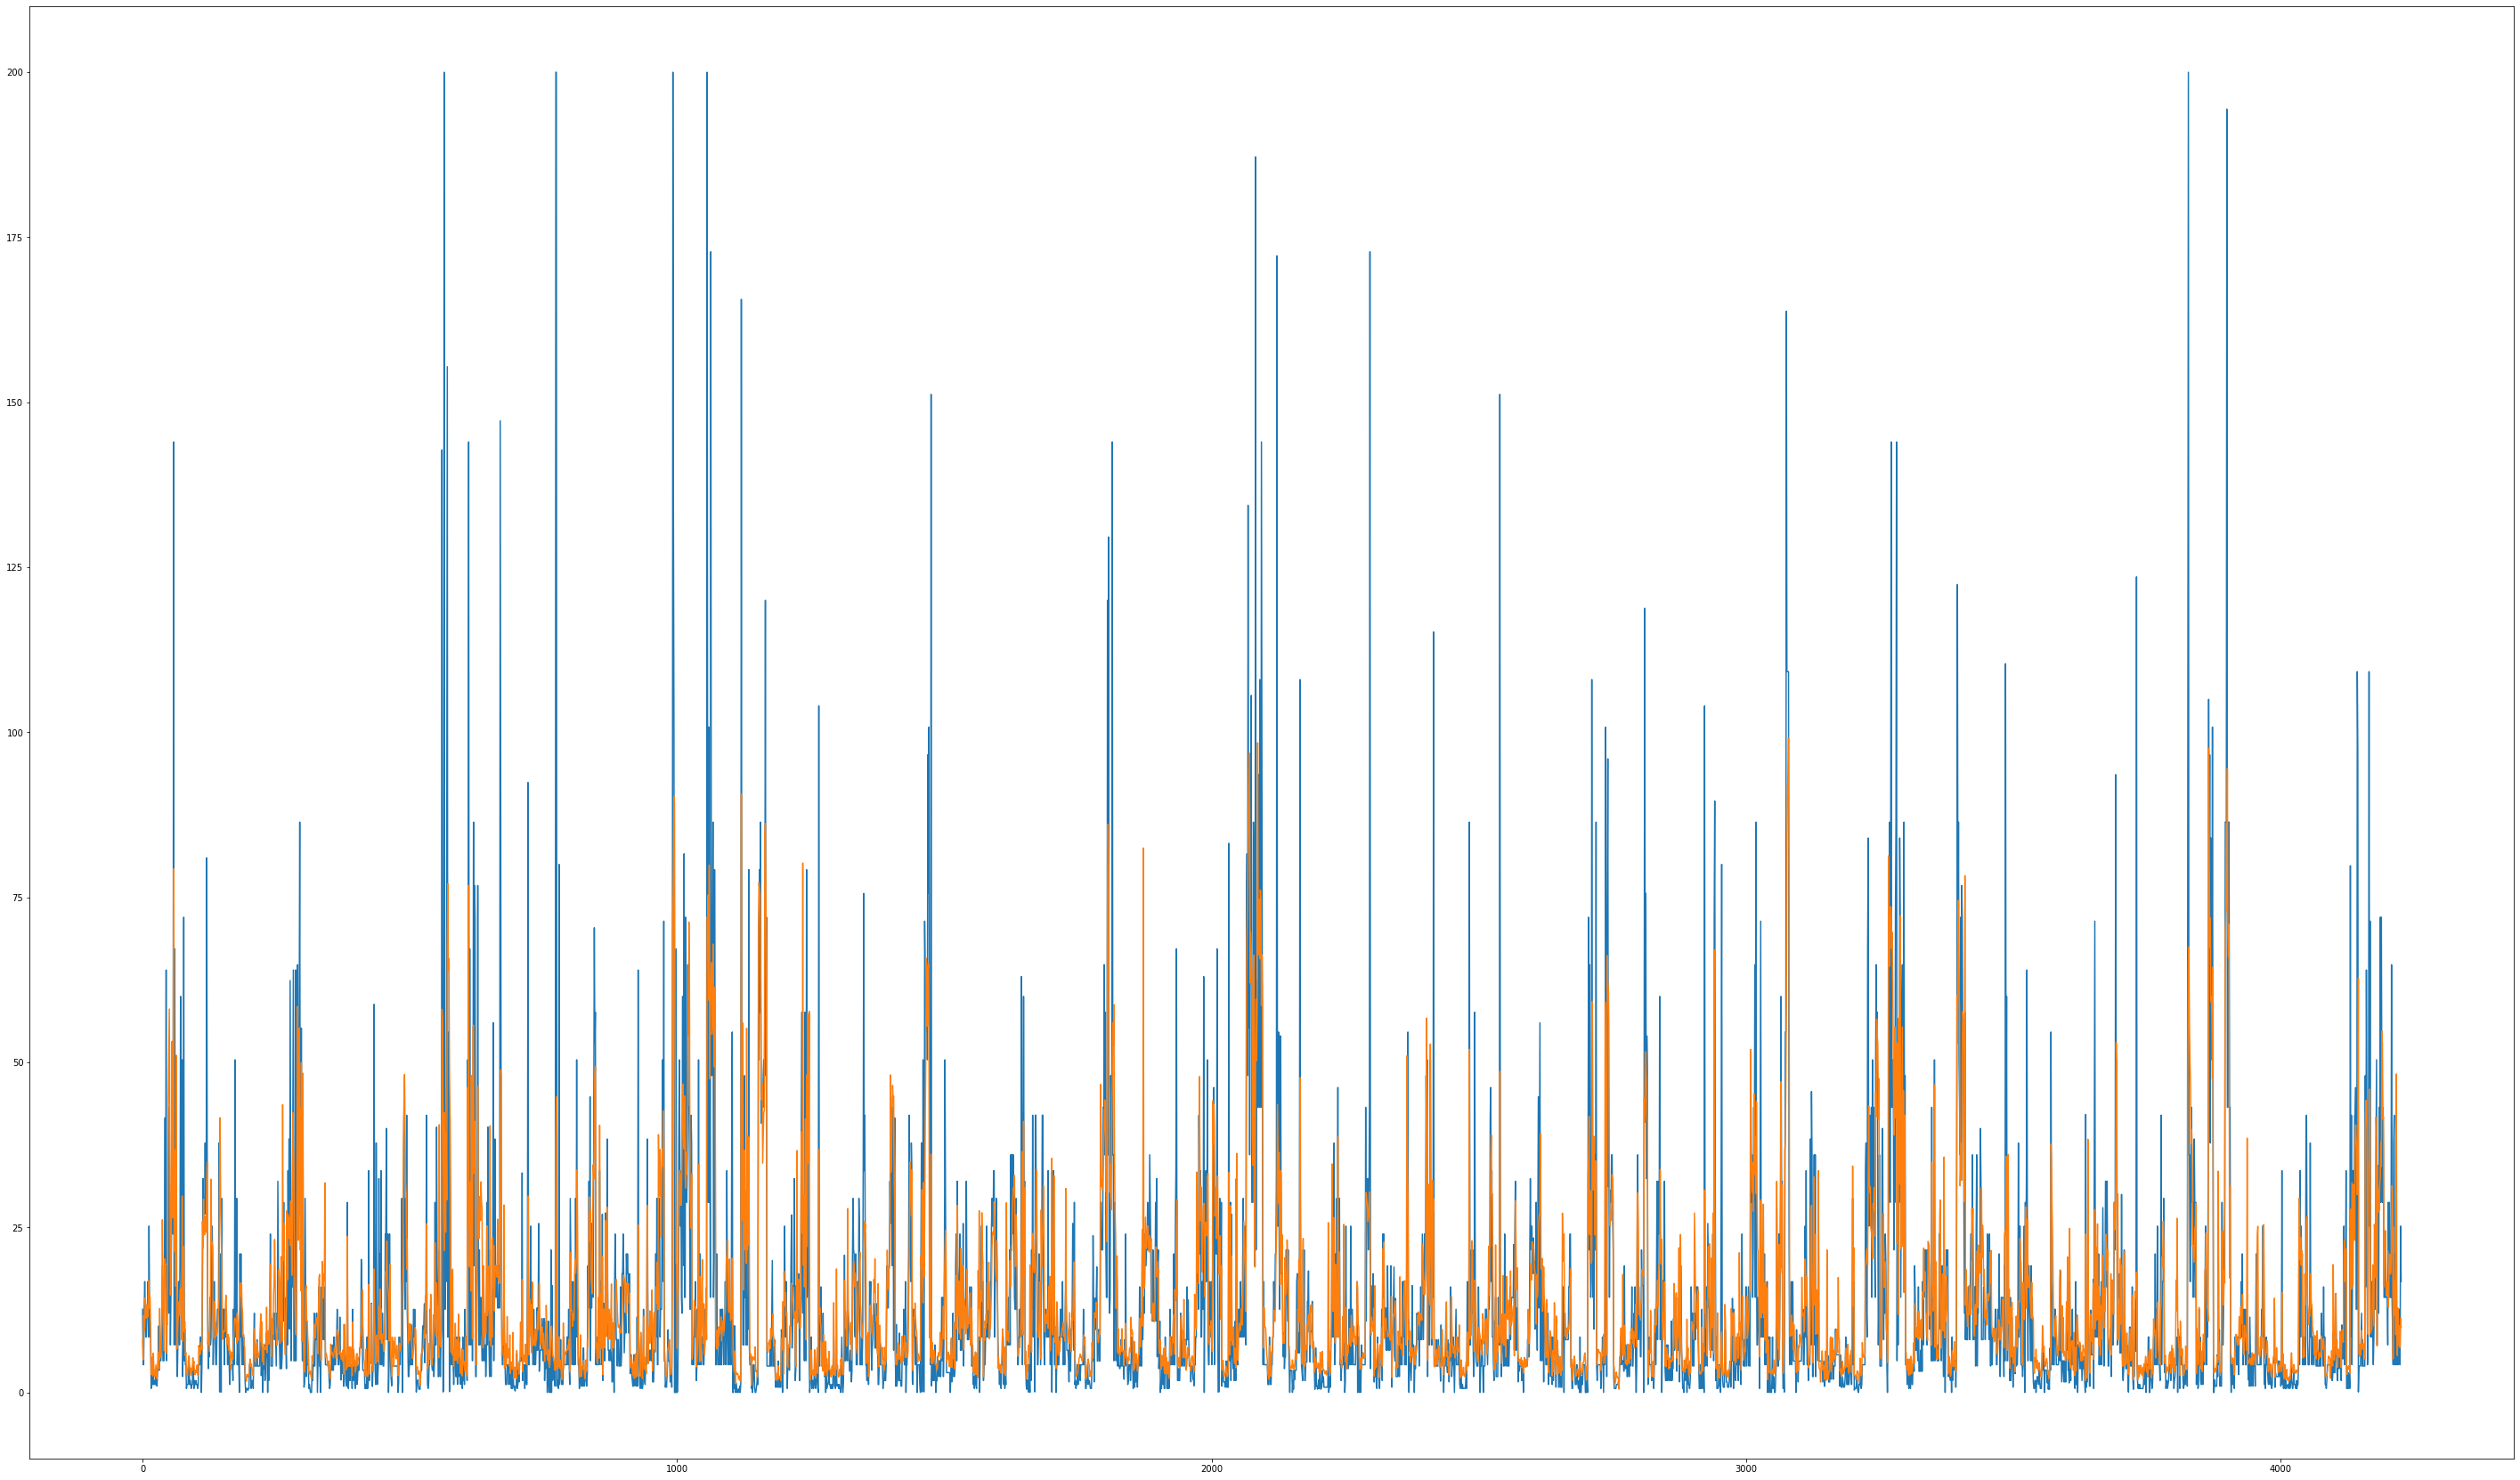

In [ ]:
plt.figure(figsize = (50, 30))
plt.plot(tests[:, 0])
plt.plot(preds[:, 0])
plt.savefig("truepred.png")

In [ ]:
# float(loss(np.concatenate([Y[:, 0:1] for Y in Y_test_batches]), np.concatenate(Y_pred_batch)))


0.07978183130698865

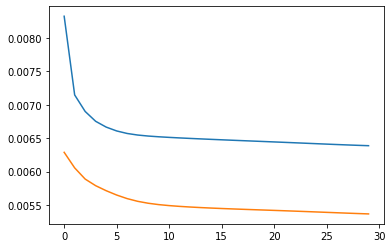

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])